In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# from lion_pytorch import Lion

from src.features import build_features_final, utils
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.config.config import seed_everything, cfg
from src.visualization.visual import plot_label_counts

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", "air_to_motor_ratio"]


# 데이터 전처리
train_data = pd.read_csv(r'data\raw\train_data.csv')
train_data = build_features_final.create_derived_features(train_data)
train_data = train_data.drop(drop_feature, axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)
test_data = test_data.drop(drop_feature, axis=1)
test_data_raw = test_data.copy()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data_df = pd.DataFrame(
    scaled_train_data, columns=train_data.columns)
scaled_test_data_df = pd.DataFrame(
    scaled_test_data, columns=train_data.columns)

n_features = scaled_train_data_df.shape[1]
print(n_features)

scaled_train_data = scaled_train_data_df.values
scaled_test_data = scaled_test_data_df.values


# 데이터 로더
dataloader = DatasetLoader(scaled_train_data, scaled_test_data)
train_loader, test_loader = dataloader.load

# # 학습 파라미터
# model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=128)
model = predict_model.SingleAutoEncoder(input_dim=n_features, hidden_dim=9)
# model = predict_model.ResidualConv1DAutoencoder()
model = predict_model.ResidualConv1DLSTMAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습
train(train_loader, model, criterion, optimizer)

# 예측
train_prediction, train_cosine = evaluation(train_loader, model)
print(min(train_cosine))
prediction, test_cosine = evaluation(test_loader, model, min(train_cosine))

# 제출W
submission = prediction_to_csv(prediction)


14
Epoch [0/300], Loss: 0.0757560
Epoch [100/300], Loss: 0.0014320
Epoch [200/300], Loss: 0.0005548
0.9818493127822876
label
0    7323
1      66
Name: count, dtype: int64


In [5]:
test_data['label'] = prediction
test_data['treshold'] = test_cosine
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [6]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 11 labels with value 1


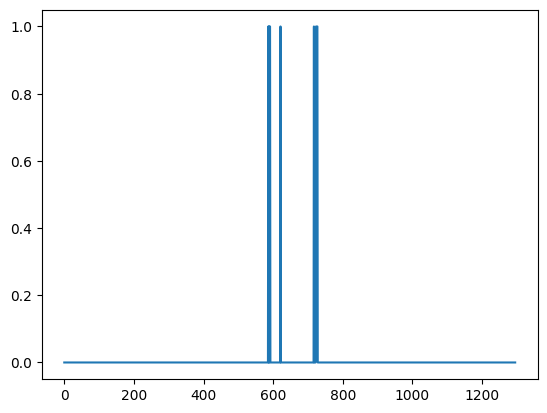

Chunk 1: 0 labels with value 1


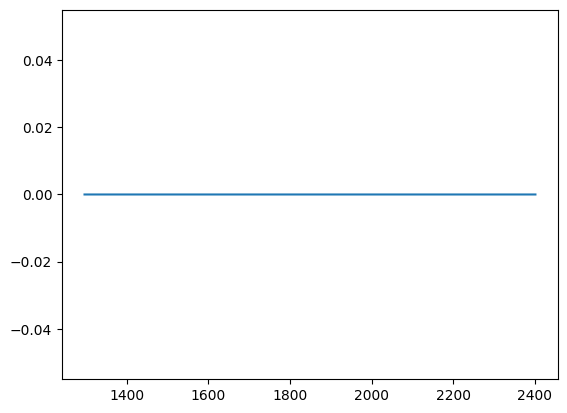

Chunk 2: 22 labels with value 1


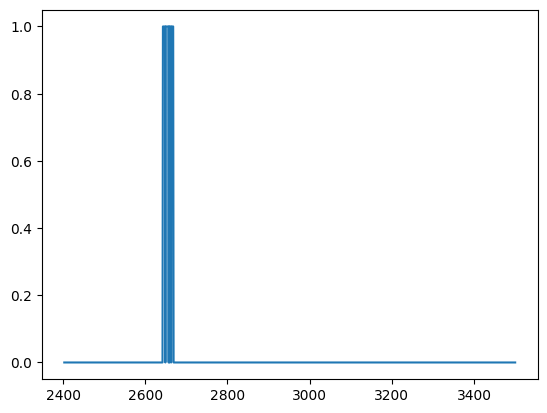

Chunk 3: 15 labels with value 1


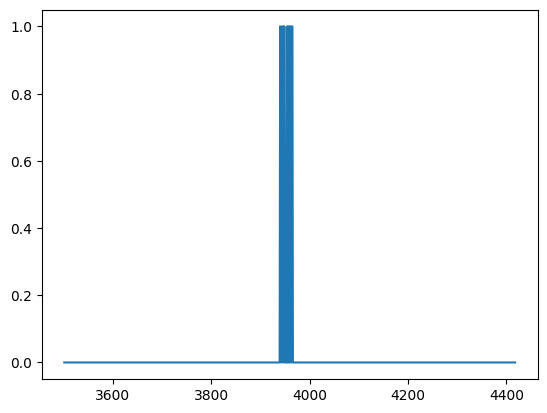

Chunk 4: 12 labels with value 1


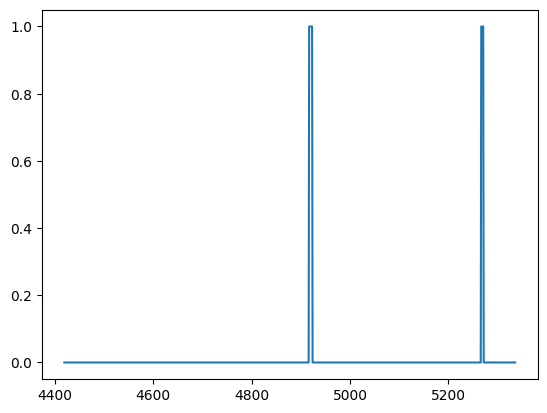

Chunk 5: 0 labels with value 1


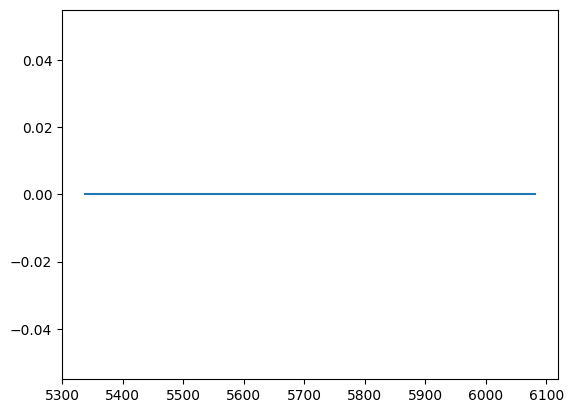

Chunk 6: 6 labels with value 1


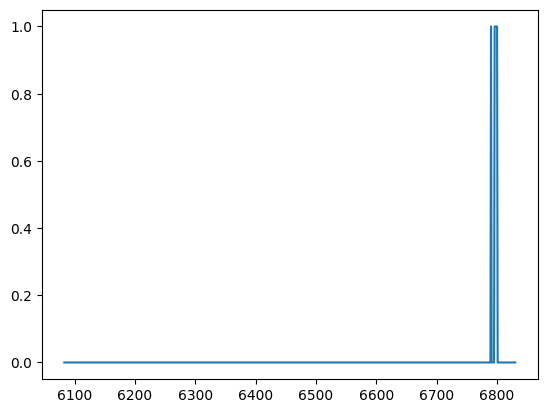

Chunk 7: 0 labels with value 1


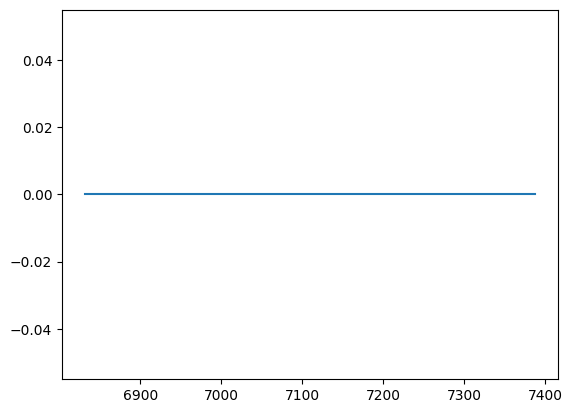

In [7]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(prediction))]
plot_label_counts(submission, ranges)